In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time

#### Setup Device

In [3]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

mps


#### Load and Normalize CIFAR-10 Data

In [4]:
batch_size = 256

mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2009, 0.2009, 0.2009])
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean = mean, std = std)])
cifar_train_data = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
cifar_test_data = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform)

cifar_train_dl = torch.utils.data.DataLoader(cifar_train_data, batch_size=batch_size, shuffle=True)
cifar_test_dl = torch.utils.data.DataLoader(cifar_test_data, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


## Define Convolutional Neural Networks

### Low-Tier CNN

In [5]:
class CIFAR_Basic_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.classifier = nn.Linear(in_features=64*16*16, out_features=10)
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### Mid-Tier CNN 

In [6]:
class CIFAR_Medium_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256*8*8, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=10)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

#### Mid-Tier CNN (with Batch Norm)

In [7]:
class CIFAR_Medium_BatchNorm_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256*8*8, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=10)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

#### Mid-Tier CNN (with batch norm + more linear layers)

In [8]:
class CIFAR_Medium_BatchNorm_LinearPlus_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256*8*8, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

#### Dataset Distillation ConvNet

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=3), #32x32 -> 36x36
            nn.GroupNorm(4, 32, eps=1e-05, affine=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0), #36x36 -> 18x18
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(4, 64, eps=1e-05, affine=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0), #18x18 -> 9x9
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(4, 128, eps=1e-05, affine=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0), #9x9 -> 4x4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(2, 512, eps=1e-05, affine=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0) #4x4 -> #2x2
        )
        self.classifier = nn.Linear(in_features=128*4*4, out_features=10, bias=True)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [10]:
class ConvNet_Simple(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=3),
            nn.GroupNorm(128, 128, eps=1e-05, affine=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(128, 128, eps=1e-05, affine=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(128, 128, eps=1e-05, affine=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.classifier = nn.Linear(in_features=2048, out_features=10, bias=True)

    def forward(self, x):
            x = self.features(x)
            x = x.view(x.shape[0], -1)
            x = self.classifier(x)
            return x

### High-Tier CNN

In [11]:
class CIFAR_High_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256*8*8, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Cosine Annealing Experiment

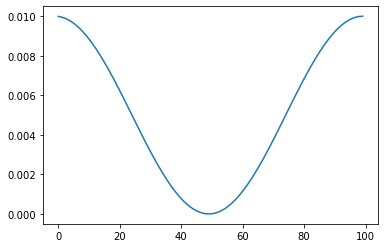

In [12]:
import matplotlib.pyplot as plt

model = torch.nn.Linear(in_features=10, out_features=10)
num_epochs=100
lrs = [0] * num_epochs
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
loss_function = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    outputs = model(torch.randn(10, 10))
    loss = loss_function(outputs, torch.randint(0, 10, size=(10,)))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    lrs[epoch] = scheduler.get_last_lr()[0]


plt.plot(lrs)

## Train and test functions

In [32]:
from tqdm import tqdm

def train(model, num_epochs, lr, train_dl, test_dl, optimizer="SGD", scheduler=False, verbose=False, patience=10):
    model.to(device)

    if optimizer == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=lr)

    if scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epochs)

    # Classification tasks should use cross entropy
    loss_function = nn.CrossEntropyLoss()

    test_accuracies = []
    train_accuracies = []
    best_test_accuracy = 0
    best_model_state_dict = None
    epochs_until_early_stop = patience

    train_start_time = time.time()
    epoch_progress_bar = tqdm(range(1, num_epochs + 1), desc="Training: ", unit="epoch")
    for epoch in epoch_progress_bar:
        model.train()
        epoch_start_time = time.time()

        for X, y in train_dl:
            X, y = X.to(device), y.to(device)

            predictions = model(X)
            loss = loss_function(predictions, y)

            opt.zero_grad()
            loss.backward()
            opt.step()
        
        if scheduler:
            scheduler.step()
        
        train_accuracy = test(model, train_dl)
        test_accuracy = test(model, test_dl)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        epoch_total_time = time.time() - epoch_start_time
        if verbose and epoch % 10 == 0:
            print(f"Epoch {epoch:>03} took {epoch_total_time:.2f}s Test Acc: {test_accuracy:.4f}")

        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_model_state_dict = model.state_dict()
            epochs_until_early_stop = patience
        else:
            epochs_until_early_stop -= 1
            if epochs_until_early_stop == 0:
                print('Model failing to improve on test data. Stopping early.')
                model.load_state_dict(best_model_state_dict)
                break
    
    total_train_time = time.time() - train_start_time
    final_test_accuracy = test(model, test_dl)
    
    print(f'Model achieved highest test accuracy of {final_test_accuracy:.4f}')
    print(f'Training took {total_train_time:.2f} seconds.')

    return train_accuracies, test_accuracies

def test(model, test_dl):
    model.to(device)
    model.eval()

    correct_predictions = 0
    total_predictions = 0
    
    # Testing, so no gradient computation is needed
    with torch.no_grad():
        for image, label in test_dl:
            image, label = image.to(device), label.to(device)

            predictions = model(image)
            _, predictions = torch.max(predictions, 1)

            correct_predictions += (predictions==label).sum().item()
            total_predictions += predictions.shape[0]
    
    return correct_predictions / total_predictions

In [162]:
models = [
    CIFAR_Basic_CNN,
    CIFAR_Medium_CNN,
    CIFAR_Medium_BatchNorm_CNN,
    CIFAR_Medium_BatchNorm_LinearPlus_CNN,
    CIFAR_High_CNN,
    ConvNet,
    ConvNet_Simple
]

model_names = [
    "CIFAR_Basic_CNN",
    "CIFAR_Medium_CNN",
    "CIFAR_Medium_BatchNorm_CNN",
    "CIFAR_Medium_BatchNorm_LinearPlus_CNN",
    "CIFAR_High_CNN",
    "ConvNet",
    "ConvNet_Simple"
]

In [ ]:
for i, model in enumerate(models):
    print(f"*****Training for Model {model_names[i]}*****")
    print('Scheduler + SGD:')
    train(model(), 150, 0.05, cifar_train_dl, cifar_test_dl, scheduler=True)
    print('\n')
    print('No Scheduler + SGD')
    train(model(), 150, 0.05, cifar_train_dl, cifar_test_dl, scheduler=False)
    print('\n')
    print('Scheduler + Adam:')
    train(model(), 150, 0.01, cifar_train_dl, cifar_test_dl, optimizer="Adam", scheduler=True)
    print('\n')
    print('No Scheduler + Adam')
    train(model(), 150, 0.01, cifar_train_dl, cifar_test_dl, optimizer="Adam", scheduler=False)
    print('\n')
    print('Scheduler + Adam, lr=0.01:')
    train(model(), 150, 0.001, cifar_train_dl, cifar_test_dl, optimizer="Adam", scheduler=True)
    print('\n')
    print('No Scheduler + Adam, lr=0.01')
    train(model(), 150, 0.001, cifar_train_dl, cifar_test_dl, optimizer="Adam", scheduler=False)
    print('\n')

In [28]:
tr_accs, test_accs = train(CIFAR_Basic_CNN(), 20, 0.05, cifar_train_dl, cifar_test_dl, scheduler=True)

Training: 100%|██████████| 20/20 [02:23<00:00,  7.18s/epoch]


Model achieved final test accuracy of 0.6191
Training took 143.56 seconds.


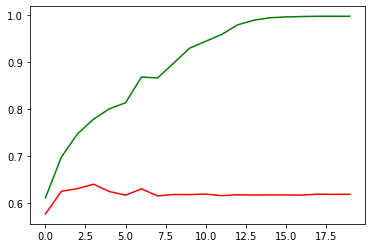

In [29]:
plt.plot(tr_accs, c="green")
plt.plot(test_accs, c="red")
plt.show()

In [ ]:
train(CIFAR_Basic_CNN(), 20, 0.05, cifar_train_dl, cifar_test_dl, scheduler=False)

In [ ]:
train(CIFAR_Medium_CNN(), 20, 0.05, cifar_train_dl, cifar_test_dl, scheduler=True)

In [ ]:
train(CIFAR_Medium_CNN(), 20, 0.05, cifar_train_dl, cifar_test_dl, scheduler=False)

In [31]:
train_accs, test_accs = train(CIFAR_Medium_BatchNorm_CNN(), 30, 0.05, cifar_train_dl, cifar_test_dl, scheduler=True)
plt.plot(train_accs, c='green')
plt.plot(test_accs, c='red')
plt.show()

Training:  40%|████      | 12/30 [07:20<11:00, 36.67s/epoch]


KeyboardInterrupt: 

In [ ]:
train_accs, test_accs = train(CIFAR_Medium_BatchNorm_CNN(), 30, 0.05, cifar_train_dl, cifar_test_dl, scheduler=False)
plt.plot(train_accs, c='green')
plt.plot(test_accs, c='red')
plt.show()

In [ ]:
train_accs, test_accs = train(CIFAR_Medium_BatchNorm_LinearPlus_CNN(), 30, 0.05, cifar_train_dl, cifar_test_dl, scheduler=True)
plt.plot(train_accs, c='green')
plt.plot(test_accs, c='red')
plt.show()

In [ ]:
train(CIFAR_High_CNN(), 30, 0.05, cifar_train_dl, cifar_test_dl, scheduler=True)

Training: 100%|██████████| 30/30 [12:33<00:00, 25.12s/epoch]


Model achieved final test accuracy of 0.7707
Training took 753.68 seconds.


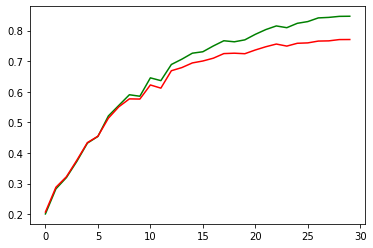

In [30]:
train_accs, test_accs = train(ConvNet(), 30, 0.05, cifar_train_dl, cifar_test_dl, scheduler=True)
plt.plot(train_accs, c='green')
plt.plot(test_accs, c='red')

In [ ]:
t1, v1 = train(ConvNet(), 50, 0.05, cifar_train_dl, cifar_test_dl, scheduler=True)
t2, v2 = train(ConvNet(), 50, 0.05, cifar_train_dl, cifar_test_dl, scheduler=False)
t3, v3 = train(ConvNet(), 50, 0.001, cifar_train_dl, cifar_test_dl, scheduler=True, optimizer="Adam")
t4, v4 = train(ConvNet(), 50, 0.001, cifar_train_dl, cifar_test_dl, scheduler=False, optimizer="Adam")
t5, v5 = train(ConvNet(), 50, 0.01, cifar_train_dl, cifar_test_dl, scheduler=True, optimizer="Adam")
t6, v6 = train(ConvNet(), 50, 0.01, cifar_train_dl, cifar_test_dl, scheduler=False, optimizer="Adam")

In [ ]:
train(ConvNet_Simple(), 30, 0.05, cifar_train_dl, cifar_test_dl, scheduler=True)
train(ConvNet_Simple(), 30, 0.05, cifar_train_dl, cifar_test_dl, scheduler=False)